# Jonathan Halverson
# Thursday, March 16, 2017
# Part 7: Is ring rust real?

One problem with this calculation is that it assumes that fighters do not fight outside the UFC in between fights.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('halverson')
from scipy.stats import t

In [2]:
iofile = 'data/fightmetric_cards/fightmetric_fights_CLEAN_3-6-2017.csv'
fights = pd.read_csv(iofile, header=0, parse_dates=['Date'])
fights.head(3)

,Winner,Outcome,Loser,WeightClass,Method,MethodNotes,Round,Time,Event,Date,Location
0,Germaine de Randamie,def.,Holly Holm,Women's Featherweight,U-DEC,NaN,5,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA"
1,Anderson Silva,def.,Derek Brunson,Middleweight,U-DEC,NaN,3,5:00,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA"
2,Jacare Souza,def.,Tim Boetsch,Middleweight,SUB,Kimura,1,3:41,UFC 208: Holm vs. De Randamie,2017-02-11,"New York, New York, USA"


In [3]:
fights = fights[(fights.Date > pd.to_datetime('2005-01-01')) & (fights.Outcome != 'no contest')]

In [4]:
from collections import defaultdict

wins = defaultdict(int)
total = defaultdict(int)
wins2 = defaultdict(int)
total2 = defaultdict(int)
wins_12 = 0
total_12 = 0
win_lose = fights.Winner.append(fights.Loser).unique()
for fighter in win_lose:
     msk = (fights.Winner == fighter) | (fights.Loser == fighter)
     all_fights = fights[msk].sort_values('Date').reset_index()
     for i in range(0, all_fights.shape[0] - 1):
          # 30.4375 = (3 * 365 + 366) / 48.
          months = (all_fights.loc[i + 1, 'Date'] - all_fights.loc[i, 'Date']) / pd.to_timedelta('30.4375 days')
          months_12 = months
          months2 = int(months / 3.0)
          months = round(months)
          if (all_fights.loc[i + 1, 'Winner'] == fighter and all_fights.loc[i + 1, 'Outcome'] == 'def.'):
               wins[months] += 1
               wins2[months2] += 1
               if (months_12 > 15.0 and months_12 <= 24.0): wins_12 += 1
          total[months] += 1
          total2[months2] += 1
          if (months_12 > 15.0 and months_12 <= 24.0): total_12 += 1

In [5]:
ws = pd.Series(data=wins.values(), index=wins.keys())
ts = pd.Series(data=total.values(), index=total.keys())

In [6]:
df = pd.DataFrame([ws, ts]).T
df.columns = ['wins', 'total']
df = df.loc[1:24]
df['WinRatio'] = df.wins / df.total
df['2se'] = 1.96 * np.sqrt(df.WinRatio * (1 - df.WinRatio) / df.total)
df

,wins,total,WinRatio,2se
1.0,25.0,52.0,0.480769,0.135801
2.0,164.0,319.0,0.514107,0.054848
3.0,408.0,797.0,0.511920,0.034704
4.0,570.0,1082.0,0.526802,0.029750
5.0,529.0,1014.0,0.521696,0.030747
6.0,382.0,719.0,0.531293,0.036476
7.0,246.0,461.0,0.533623,0.045540
8.0,135.0,284.0,0.475352,0.058082
9.0,147.0,256.0,0.574219,0.060571
10.0,78.0,162.0,0.481481,0.076943


In [7]:
df.loc[15:25].sum(axis=0)

wins         79.000000
total       201.000000
WinRatio      3.864580
2se           2.507101
dtype: float64

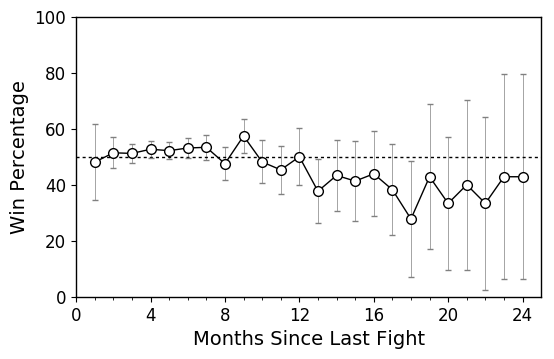

In [8]:
fig, ax = plt.subplots()
plt.plot([0, 25], [50, 50], 'k:')
plt.errorbar(df.index, 100 * df.WinRatio, color='k', marker='o', mfc='w', yerr=100*df['2se'], ecolor='gray', elinewidth=0.5, capsize=2)
#plt.plot(df.index, 100 * df.WinRatio, 'wo')
plt.xlabel('Months Since Last Fight')
plt.ylabel('Win Percentage')
plt.xlim(0, 25)
plt.ylim(0, 100)
major_ticks = np.arange(0, 28, 4)
ax.set_xticks(major_ticks)
minor_ticks = np.arange(0, 25, 1)
ax.set_xticks(minor_ticks, minor = True)
#plt.savefig('report/ring_rust.pdf', bbox_inches='tight')

### Months bracket

In [9]:
ws = pd.Series(data=wins2.values(), index=wins2.keys())
ts = pd.Series(data=total2.values(), index=total2.keys())

In [10]:
df = pd.DataFrame([ws, ts]).T
df.columns = ['wins', 'total']
df = df.loc[0:4]
df.loc[5] = [wins_12, total_12]
df['WinRatio'] = df.wins / df.total
df['2se'] = -t.ppf(0.025, df.total - 1) * np.sqrt(df.WinRatio * (1 - df.WinRatio) / df.total)
df

,wins,total,WinRatio,2se
0,377.0,755.0,0.499338,0.035723
1,1552.0,2944.0,0.527174,0.018042
2,626.0,1198.0,0.522538,0.028313
3,218.0,434.0,0.502304,0.047172
4,79.0,188.0,0.420213,0.071016
5,70.0,180.0,0.388889,0.071702


In [11]:
df.index = [0, 1, 2, 3, 4, 5.5]

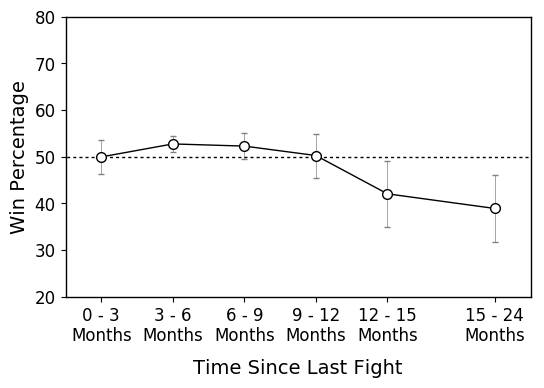

In [21]:
fig, ax = plt.subplots()
plt.plot([-1, 12], [50, 50], 'k:')
plt.errorbar(df.index, 100 * df.WinRatio, color='k', marker='o', mfc='w', yerr=100*df['2se'], ecolor='gray', elinewidth=0.5, capsize=2)
#plt.plot(df.index, 100 * df.WinRatio, 'wo')
plt.xlabel('Time Since Last Fight', labelpad=10)
plt.ylabel('Win Percentage')
plt.xlim(-.5, 6)
plt.ylim(20, 80)
major_ticks = [0, 1, 2, 3, 4, 5.5]
ax.set_xticks(major_ticks)
ax.set_xticklabels(['0 - 3\nMonths', '3 - 6\nMonths', '6 - 9\nMonths', '9 - 12\nMonths', '12 - 15\nMonths', '15 - 24\nMonths'])
#minor_ticks = np.arange(0, 25, 1)
#ax.set_xticks(minor_ticks, minor = True)
#plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
#fig.subplots_adjust(bottom=0.0)
plt.savefig('report/age/ring_rust.pdf', bbox_inches='tight')

In [13]:
from scipy.stats import chi2_contingency

In [14]:
df['loses'] = df.total - df.wins
chi2, p, dof, expt = chi2_contingency(df[['wins', 'loses']])
chi2, p

(21.14081472468656, 0.00076190585655320901)

In [15]:
df[['wins', 'loses']].T

,0.0,1.0,2.0,3.0,4.0,5.5
wins,377.0,1552.0,626.0,218.0,79.0,70.0
loses,378.0,1392.0,572.0,216.0,109.0,110.0


In [16]:
expt.T

array([[  387.10475522,  1509.45218459,   614.24039305,   222.52114406,
           96.39164766,    92.28987542],
       [  367.89524478,  1434.54781541,   583.75960695,   211.47885594,
           91.60835234,    87.71012458]])

In [17]:
tmp_table = df[['wins', 'loses']]
N = tmp_table.sum().sum()
V = (chi2 / (N * min(tmp_table.shape[0] - 1, tmp_table.shape[1] - 1)))**0.5
V

0.060906203829937992

In [18]:
chi2, p, dof, expt = chi2_contingency(df[['wins', 'total']])
chi2, p

(7.2558205845428887, 0.20229918634794494)

In [19]:
df[['wins', 'total']].T

,0.0,1.0,2.0,3.0,4.0,5.5
wins,377.0,1552.0,626.0,218.0,79.0,70.0
total,755.0,2944.0,1198.0,434.0,188.0,180.0


In [20]:
expt.T

array([[  383.67985153,  1523.87333256,   618.22619186,   220.98874841,
           90.49692611,    84.73494954],
       [  748.32014847,  2972.12666744,  1205.77380814,   431.01125159,
          176.50307389,   165.26505046]])